In [53]:
import polars as pl
import matplotlib.pyplot as plt
import os
import numpy as np


In [54]:
def moving_average(x, window=20):
    """
    Compute a moving average with given window.

    Uses 'same' convolution so edges are smoothed with smaller effective window.
    """
    w = np.ones(window, dtype=float) / window
    return np.convolve(x, w, mode='same')

def plot_rewards_from_csv(file_path, window=20):
    # Load rewards data from CSV file using polars
    df = pl.read_csv(file_path)
    
    episodes = df['episode'].to_numpy()
    rewards = df['reward'].to_numpy()
    
    # Compute moving average
    rewards_ma = moving_average(rewards, window=window)
    
    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(episodes, rewards, label='Rewards', alpha=0.3)
    plt.plot(episodes, rewards_ma, label=f'Moving Average (window={window})', color='orange')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Episode Rewards with Moving Average')
    plt.legend()
    plt.grid()
    plt.show()

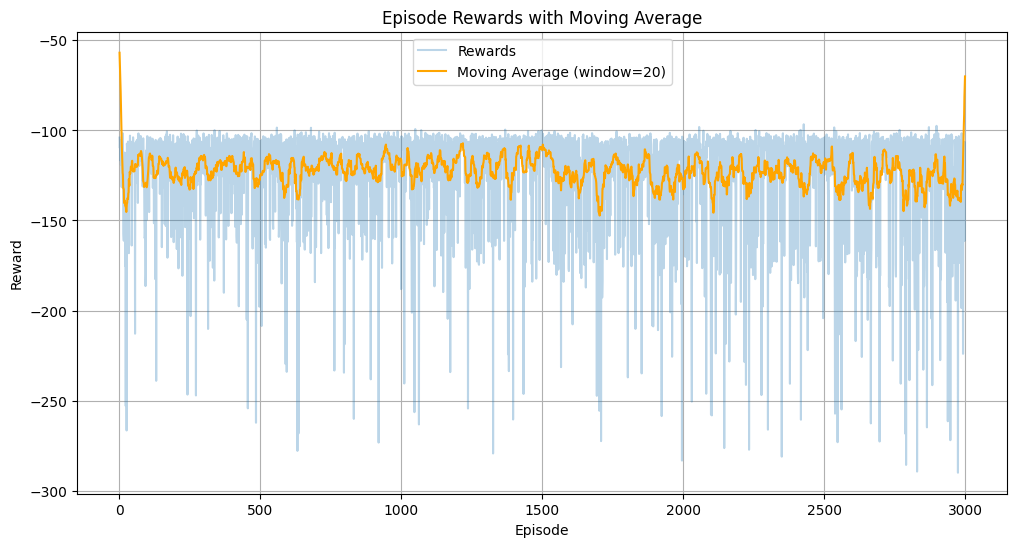

In [55]:
curr_dir = os.path.dirname(os.path.abspath(os.curdir))
file_path = os.path.join(curr_dir, "results", "a2c_single_env.csv")
plot_rewards_from_csv(file_path, window=20)

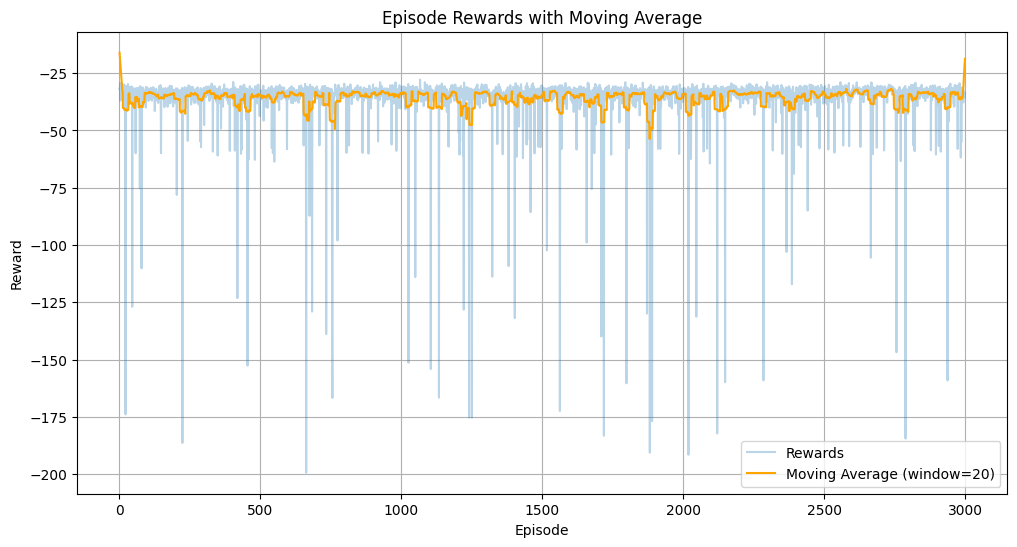

In [56]:
curr_dir = os.path.dirname(os.path.abspath(os.curdir))
file_path = os.path.join(curr_dir, "results", "a2c_four_envs.csv")
plot_rewards_from_csv(file_path, window=20)

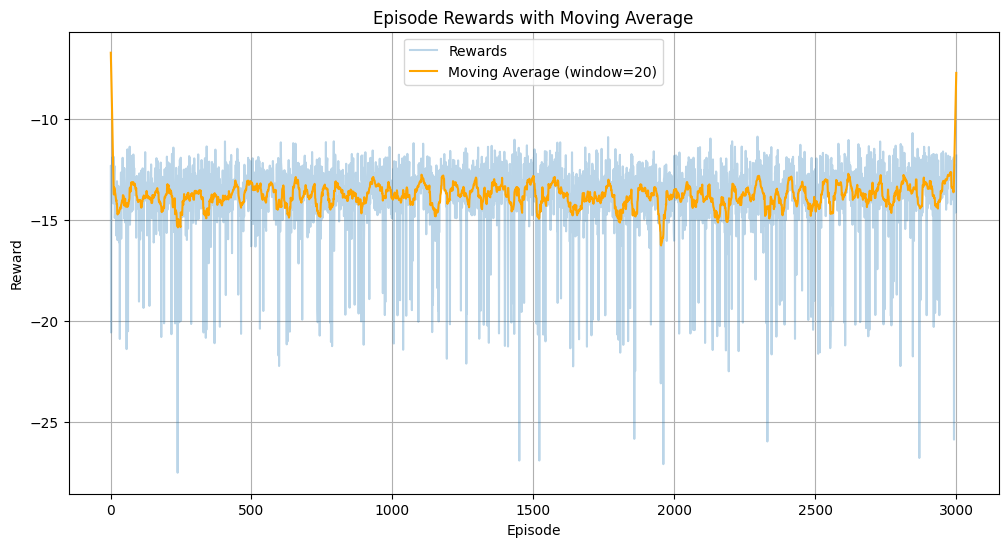

In [57]:
curr_dir = os.path.dirname(os.path.abspath(os.curdir))
file_path = os.path.join(curr_dir, "results", "a2c_16_envs.csv")
plot_rewards_from_csv(file_path, window=20)

In [58]:
def plot_profiler_top_k(csv_path, k=20, sort_by='self_cpu_time_total_us'):
    """
    Plot top-K functions from profiler summary CSV.
    
    Args:
        csv_path: Path to profiler summary CSV
        k: Number of top functions to display
        sort_by: Column to sort by ('self_cpu_time_total_us', 'self_cuda_time_total_us', etc.)
    """
    df = pl.read_csv(csv_path)
    
    # Filter out zero times and sort
    df_filtered = df.filter(pl.col(sort_by) > 0).sort(sort_by, descending=True).head(k)
    
    # Truncate names to at most 10 characters for readability
    df_filtered = df_filtered.with_columns(pl.col('name').str.slice(0, 10).alias('name'))
    
    # Convert microseconds to milliseconds for readability
    names = df_filtered['name'].to_list()
    times_ms = (df_filtered[sort_by] / 1000.0).to_numpy()
    
    # Create bar chart
    plt.figure(figsize=(12, 8))
    y_pos = np.arange(len(names))
    plt.barh(y_pos, times_ms, align='center', alpha=0.8, color='steelblue')
    plt.yticks(y_pos, names, fontsize=9)
    plt.xlabel('Time (ms)', fontsize=11)
    plt.title(f'Top {k} Operations by {sort_by.replace("_", " ").title()}', fontsize=13)
    plt.gca().invert_yaxis()  # Highest at top
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

# Plot profiler results
profiler_csv = os.path.join(curr_dir, "profiler", "a2c_config", "a2c_config_summary.csv")

# plot_profiler_top_k(profiler_csv, k=20, sort_by='cpu_time')

# CocoDoom Dataset

In [59]:
import json
import os

file_path = "/home/xavier/projects/datasets/cocodoom/run-val.json"

with open(file_path, 'r') as f:
    data = json.load(f)

print(data["info"])
print(data.keys())

print(len(data["categories"]))

for cat in data["categories"]:
    print(cat)

{'year': 2016, 'version': 1, 'description': 'ResearchDoom', 'contributor': 'VGG', 'url': '', 'date_created': '03-Oct-2016 15:52:14'}
dict_keys(['info', 'images', 'annotations', 'categories', 'licenses'])
94
{'id': 1, 'name': 'POSSESSED', 'supercategory': ''}
{'id': 2, 'name': 'SHOTGUY', 'supercategory': ''}
{'id': 3, 'name': 'VILE', 'supercategory': ''}
{'id': 4, 'name': 'FIRE', 'supercategory': ''}
{'id': 5, 'name': 'UNDEAD', 'supercategory': ''}
{'id': 6, 'name': 'TRACER', 'supercategory': ''}
{'id': 7, 'name': 'SMOKE', 'supercategory': ''}
{'id': 8, 'name': 'FATSO', 'supercategory': ''}
{'id': 9, 'name': 'FATSHOT', 'supercategory': ''}
{'id': 10, 'name': 'CHAINGUY', 'supercategory': ''}
{'id': 11, 'name': 'TROOP', 'supercategory': ''}
{'id': 12, 'name': 'SERGEANT', 'supercategory': ''}
{'id': 14, 'name': 'HEAD', 'supercategory': ''}
{'id': 15, 'name': 'BRUISER', 'supercategory': ''}
{'id': 16, 'name': 'BRUISERSHOT', 'supercategory': ''}
{'id': 17, 'name': 'KNIGHT', 'supercategory': 

In [60]:
import os
import torch
from torch.utils.data import Dataset
import torchvision
from pycocotools.coco import COCO
from PIL import Image
from pathlib import Path
from collections import OrderedDict
import threading


class CocoDoomDataset(torchvision.datasets.CocoDetection):
    """
    Custom COCO dataset for training a DETR model.
    """

    def __init__(
        self, data_dir, annotation_file_name,
        processor
    ):
        """
        Args:
            data_dir: Path to dataset
            annotation_file_name: Name of the COCO annotation file
            processor: DETR image processor
        """
        # load COCO annotation
        annotation_file = os.path.join(
            data_dir, annotation_file_name)
        super().__init__(root=data_dir, annFile=annotation_file)

        self.img_folder = data_dir
        self.coco = COCO(annotation_file)
        self.processor = processor
        self.id2label = self.coco.loadCats(self.coco.getCatIds())
        # Map COCO category ids (which may be non-contiguous) to contiguous 0-based ids
        # expected by DETR's classification head.
        self.cat_id_to_contiguous_id = {
            cat_id: idx for idx, cat_id in enumerate(self.coco.getCatIds())
        }

        # identifier for each image in dataset
        self.img_ids = list(self.coco.imgs.keys())

        # Remap all annotations once during initialization to avoid doing it every __getitem__
        for ann_id, ann in self.coco.anns.items():
            ann['category_id'] = self.cat_id_to_contiguous_id[ann['category_id']]

        print(f"Loaded {annotation_file_name}")
        print(f"Number of images: {len(self.coco.imgs)}")
        print(f"Number of Categories: {len(self.coco.getCatIds())}")

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        """
        Get a single image and its target.

        Uses the processor.
        """
        img, target = super(CocoDoomDataset, self).__getitem__(idx)
        img_id = self.img_ids[idx]

        print(target)

        new_target = {'image_id': img_id, 'annotations': target}

        # preprocess data
        encoding = self.processor(
            images=img,
            annotations=new_target,
            return_tensors="pt"
        )

        # squeeze and [0] to remove batch dimension
        pixel_values = encoding["pixel_values"].squeeze()
        new_target = encoding["labels"][0]

        return pixel_values, new_target, target


    def get_image(self, idx):
        """
            Get a single image by index.
            """
        # For DETR models, we can use this line of code to
        # obtain appropriate structure for the annotations
        img, target = super(CocoDoomDataset, self).__getitem__(idx)
        img_id = self.img_ids[idx]
        img_info = self.coco.loadImgs(img_id)
        # print(img_info)
        img_info = img_info[0]

        # print("img id: ", img_id, " and ",  "are equal " if img_id == target[0]['image_id'] else "not equal")
        target = {'image_id': img_id, 'annotations': target}

        return img, target, img_info["file_name"]

In [61]:
# fixing category IDs for detr models
from transformers import RTDetrImageProcessorFast

processor = RTDetrImageProcessorFast.from_pretrained("PekingU/rtdetr_r50vd")

dataset = CocoDoomDataset(
    data_dir=os.path.join(os.pardir, os.pardir, "datasets", "cocodoom"),
    annotation_file_name="run-train.json",
    processor=processor
)

ids = dataset.ids
print(type(ids))

loading annotations into memory...
Done (t=0.92s)
creating index...
index created!
loading annotations into memory...
Done (t=0.91s)
creating index...
index created!
Loaded run-train.json
Number of images: 50732
Number of Categories: 94
<class 'list'>


In [62]:
print(len(ids))

for id in ids:
    print(id)

50732
1010000002
1010000007
1010000012
1010000017
1010000022
1010000027
1010000032
1010000037
1010000042
1010000047
1010000052
1010000057
1010000062
1010000067
1010000072
1010000077
1010000082
1010000087
1010000092
1010000097
1010000102
1010000107
1010000112
1010000117
1010000122
1010000127
1010000132
1010000137
1010000142
1010000147
1010000152
1010000157
1010000162
1010000167
1010000172
1010000177
1010000182
1010000187
1010000192
1010000197
1010000202
1010000207
1010000212
1010000217
1010000222
1010000227
1010000232
1010000237
1010000242
1010000247
1010000252
1010000257
1010000262
1010000267
1010000272
1010000277
1010000282
1010000287
1010000292
1010000297
1010000302
1010000307
1010000312
1010000317
1010000322
1010000327
1010000332
1010000337
1010000342
1010000347
1010000352
1010000357
1010000362
1010000367
1010000372
1010000377
1010000382
1010000387
1010000392
1010000397
1010000402
1010000407
1010000412
1010000417
1010000422
1010000427
1010000432
1010000437
1010000442
1010000447
1010

In [63]:
coco = dataset.coco
print(type(coco))

for cat in coco.loadCats(coco.getCatIds()):
    print(cat)

<class 'pycocotools.coco.COCO'>
{'id': 1, 'name': 'POSSESSED', 'supercategory': ''}
{'id': 2, 'name': 'SHOTGUY', 'supercategory': ''}
{'id': 3, 'name': 'VILE', 'supercategory': ''}
{'id': 4, 'name': 'FIRE', 'supercategory': ''}
{'id': 5, 'name': 'UNDEAD', 'supercategory': ''}
{'id': 6, 'name': 'TRACER', 'supercategory': ''}
{'id': 7, 'name': 'SMOKE', 'supercategory': ''}
{'id': 8, 'name': 'FATSO', 'supercategory': ''}
{'id': 9, 'name': 'FATSHOT', 'supercategory': ''}
{'id': 10, 'name': 'CHAINGUY', 'supercategory': ''}
{'id': 11, 'name': 'TROOP', 'supercategory': ''}
{'id': 12, 'name': 'SERGEANT', 'supercategory': ''}
{'id': 14, 'name': 'HEAD', 'supercategory': ''}
{'id': 15, 'name': 'BRUISER', 'supercategory': ''}
{'id': 16, 'name': 'BRUISERSHOT', 'supercategory': ''}
{'id': 17, 'name': 'KNIGHT', 'supercategory': ''}
{'id': 18, 'name': 'SKULL', 'supercategory': ''}
{'id': 19, 'name': 'SPIDER', 'supercategory': ''}
{'id': 20, 'name': 'BABY', 'supercategory': ''}
{'id': 21, 'name': 'CYBO

In [64]:
cat_list = coco.loadCats(coco.getCatIds())

# create contiguous category id mapping to handle
# inconsistent category ids in CocoDoom
sorted_cats = sorted(cat_list, key=lambda x: x['id'])
print(sorted_cats)

# Map original COCO IDs to contiguous 0-indexed IDs
coco_id_to_contiguous = {
    cat['id']: idx for idx, cat in enumerate(sorted_cats)
}
contiguous_to_coco_id = {
    idx: cat['id'] for idx, cat in enumerate(sorted_cats)
}

# Create clean 0-indexed category mappings
id2cat = {
    idx: cat['name'] for idx, cat in enumerate(sorted_cats)
}
cat2id = {
    cat['name']: idx for idx, cat in enumerate(sorted_cats)
}


print(contiguous_to_coco_id)

print(cat2id)

[{'id': 1, 'name': 'POSSESSED', 'supercategory': ''}, {'id': 2, 'name': 'SHOTGUY', 'supercategory': ''}, {'id': 3, 'name': 'VILE', 'supercategory': ''}, {'id': 4, 'name': 'FIRE', 'supercategory': ''}, {'id': 5, 'name': 'UNDEAD', 'supercategory': ''}, {'id': 6, 'name': 'TRACER', 'supercategory': ''}, {'id': 7, 'name': 'SMOKE', 'supercategory': ''}, {'id': 8, 'name': 'FATSO', 'supercategory': ''}, {'id': 9, 'name': 'FATSHOT', 'supercategory': ''}, {'id': 10, 'name': 'CHAINGUY', 'supercategory': ''}, {'id': 11, 'name': 'TROOP', 'supercategory': ''}, {'id': 12, 'name': 'SERGEANT', 'supercategory': ''}, {'id': 14, 'name': 'HEAD', 'supercategory': ''}, {'id': 15, 'name': 'BRUISER', 'supercategory': ''}, {'id': 16, 'name': 'BRUISERSHOT', 'supercategory': ''}, {'id': 17, 'name': 'KNIGHT', 'supercategory': ''}, {'id': 18, 'name': 'SKULL', 'supercategory': ''}, {'id': 19, 'name': 'SPIDER', 'supercategory': ''}, {'id': 20, 'name': 'BABY', 'supercategory': ''}, {'id': 21, 'name': 'CYBORG', 'superc

In [65]:
print(coco_id_to_contiguous)

{1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9, 11: 10, 12: 11, 14: 12, 15: 13, 16: 14, 17: 15, 18: 16, 19: 17, 20: 18, 21: 19, 22: 20, 23: 21, 30: 22, 31: 23, 32: 24, 33: 25, 34: 26, 35: 27, 36: 28, 37: 29, 38: 30, 39: 31, 42: 32, 43: 33, 44: 34, 45: 35, 46: 36, 47: 37, 53: 38, 54: 39, 55: 40, 56: 41, 57: 42, 58: 43, 59: 44, 60: 45, 62: 46, 63: 47, 64: 48, 65: 49, 66: 50, 67: 51, 68: 52, 69: 53, 70: 54, 71: 55, 72: 56, 73: 57, 74: 58, 75: 59, 76: 60, 77: 61, 78: 62, 79: 63, 80: 64, 82: 65, 83: 66, 84: 67, 88: 68, 89: 69, 90: 70, 91: 71, 92: 72, 93: 73, 94: 74, 95: 75, 96: 76, 97: 77, 99: 78, 100: 79, 106: 80, 108: 81, 109: 82, 110: 83, 117: 84, 118: 85, 119: 86, 121: 87, 123: 88, 124: 89, 125: 90, 126: 91, 127: 92, 134: 93}


In [66]:
print(id2cat)

{0: 'POSSESSED', 1: 'SHOTGUY', 2: 'VILE', 3: 'FIRE', 4: 'UNDEAD', 5: 'TRACER', 6: 'SMOKE', 7: 'FATSO', 8: 'FATSHOT', 9: 'CHAINGUY', 10: 'TROOP', 11: 'SERGEANT', 12: 'HEAD', 13: 'BRUISER', 14: 'BRUISERSHOT', 15: 'KNIGHT', 16: 'SKULL', 17: 'SPIDER', 18: 'BABY', 19: 'CYBORG', 20: 'PAIN', 21: 'WOLFSS', 22: 'BARREL', 23: 'TROOPSHOT', 24: 'HEADSHOT', 25: 'ROCKET', 26: 'PLASMA', 27: 'BFG', 28: 'ARACHPLAZ', 29: 'PUFF', 30: 'BLOOD', 31: 'TFOG', 32: 'EXTRABFG', 33: 'MISC0', 34: 'MISC1', 35: 'MISC2', 36: 'MISC3', 37: 'MISC4', 38: 'MISC10', 39: 'MISC11', 40: 'MISC12', 41: 'INV', 42: 'MISC13', 43: 'INS', 44: 'MISC14', 45: 'MISC15', 46: 'MEGA', 47: 'CLIP', 48: 'MISC17', 49: 'MISC18', 50: 'MISC19', 51: 'MISC20', 52: 'MISC21', 53: 'MISC22', 54: 'MISC23', 55: 'MISC24', 56: 'MISC25', 57: 'CHAINGUN', 58: 'MISC26', 59: 'MISC27', 60: 'MISC28', 61: 'SHOTGUN', 62: 'SUPERSHOTGUN', 63: 'MISC29', 64: 'MISC30', 65: 'MISC32', 66: 'MISC33', 67: 'MISC34', 68: 'MISC38', 69: 'MISC39', 70: 'MISC40', 71: 'MISC41', 72: 

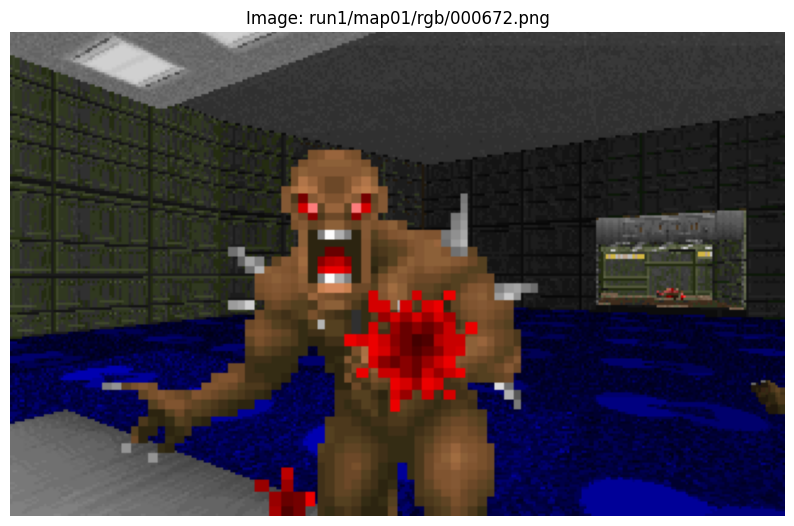

2
0
10
10
30
30


In [67]:
from PIL import Image

# Example 1: Display an image from the dataset using matplotlib
img, target, file_name = dataset.get_image(134)
plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.title(f"Image: {file_name}")
plt.axis('off')
plt.show()


print(len(target))

for ann in target['annotations']:
    print(ann['category_id'])

In [69]:
for i in range(len(dataset)):
    img, target, file_name = dataset.get_image(i)

    for ann in target['annotations']:
        if ann['category_id'] > 93:
            print("Error: category_id greater than 93 found:", ann['category_id'], " in idx ", i)